
# 📊 IRWA Sports Analysis — Live Match H2H & Win Probability

This notebook mirrors the flow used by **matches.html** and the **AnalysisAgent**:

1. Fetch **live** and **finished** matches (AllSports).
2. Pick one **live match** (or a recent finished match as fallback).
3. Retrieve **H2H** records.
4. Compute **win probability** using the AnalysisAgent (H2H-driven and Auto).
5. (Optional) Compare with provider probabilities.


## 1) Setup: imports, paths, and config

In [1]:

import json, glob, datetime as dt
from typing import Any, Dict, List, Optional
import pandas as pd

import os, sys

# Expect to run from your repo's `sports-ai/notebooks/` folder.
PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
BACKEND_ROOT = os.path.join(PROJ_ROOT, "sports-ai", "backend")

# Fallback search upwards if needed
if not os.path.isdir(BACKEND_ROOT):
    here = os.path.abspath(os.getcwd())
    for up in range(6):
        cand = os.path.abspath(os.path.join(here, *([".."]*up), "sports-ai", "backend"))
        if os.path.isdir(cand):
            BACKEND_ROOT = cand
            break

if BACKEND_ROOT not in sys.path:
    sys.path.insert(0, BACKEND_ROOT)

# Import from the app package (note the 'app.' prefix)
from app.routers.router_collector import RouterCollector
from app.agents.analysis_agent import AnalysisAgent

# Optional sanity check
assert os.path.isfile(os.path.join(BACKEND_ROOT, "app", "__init__.py")), "app package not found"
print("Using BACKEND_ROOT:", BACKEND_ROOT)


ALLSPORTS_KEY = os.getenv("ALLSPORTS_API_KEY")
print("ALLSPORTS_API_KEY set?" , bool(ALLSPORTS_KEY))

def _rows_from_data(data: Any) -> List[Dict[str, Any]]:
    if isinstance(data, list):
        return data
    if isinstance(data, dict):
        for k in ("result","results","events","fixtures","matches","games"):
            v = data.get(k)
            if isinstance(v, list):
                return v
    return []

def _normalize_match(m: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "event_key": m.get("event_key") or m.get("event_id") or m.get("match_id") or m.get("idEvent"),
        "league": m.get("league_name") or m.get("league"),
        "home": m.get("event_home_team") or m.get("homeTeam") or m.get("home_team"),
        "away": m.get("event_away_team") or m.get("awayTeam") or m.get("away_team"),
        "date": m.get("event_date") or m.get("match_date") or m.get("date"),
        "time": m.get("event_time") or m.get("match_time") or m.get("time"),
        "status": m.get("event_status") or m.get("status"),
    }

rc = RouterCollector()
agent = rc.analysis


Using BACKEND_ROOT: /Users/vishwaperera/Desktop/Projects/Sports-Analysis/sports-ai/backend
ALLSPORTS_API_KEY set? True


## 2) Live matches

In [2]:

live_resp = rc.handle({"intent":"events.live", "args": {}})
print("events.live ok:", live_resp.get("ok"))
live_rows = _rows_from_data(live_resp.get("data"))
import pandas as pd
live_df = pd.DataFrame([_normalize_match(m) for m in live_rows]) if live_rows else pd.DataFrame()
live_df.head(10)


events.live ok: True


,event_key,league,home,away,date,time,status
0,1600294,WK-League,Sejong Sportstoto W,Mungyeong Sangmu W,2025-09-04,12:00,Half Time
1,1654686,Premier League,Tsirang,Samtse,2025-09-04,12:00,45+
2,1667376,Club Friendlies - Club Friendlies 5,Brommapojkarna,Hammarby,2025-09-04,12:45,7
3,1672854,Club Friendlies,Grazer AK,A. Klagenfurt,2025-09-04,11:00,Finished
4,1672855,Club Friendlies,Den Bosch,Eindhoven FC,2025-09-04,12:00,Half Time
5,1672929,King's Cup,Iraq,Hong Kong,2025-09-04,11:00,90+


## 3) Finished matches (recent 7-day window)

In [3]:

to_dt = dt.datetime.utcnow().date()
from_dt = to_dt - dt.timedelta(days=7)
fix_args = {"from": str(from_dt), "to": str(to_dt)}

fix_resp = rc.handle({"intent":"fixtures.list", "args": fix_args})
print("fixtures.list ok:", fix_resp.get("ok"), "window:", fix_args)
fix_rows = _rows_from_data(fix_resp.get("data"))
fix_df = pd.DataFrame([_normalize_match(m) for m in fix_rows]) if fix_rows else pd.DataFrame()
fix_df.head(10)


/var/folders/9y/rhnq7_gj2_v_y6jhl2r06jx00000gn/T/ipykernel_45229/194905793.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  to_dt = dt.datetime.utcnow().date()


fixtures.list ok: True window: {'from': '2025-08-28', 'to': '2025-09-04'}


,event_key,league,home,away,date,time,status
0,1631429,UEFA World Cup Qualifiers - Group Stage,Kazakhstan,Wales,2025-09-04,16:00,None
1,1631430,UEFA World Cup Qualifiers - Group Stage,Georgia,Turkey,2025-09-04,18:00,None
2,1631431,UEFA World Cup Qualifiers - Group Stage,Lithuania,Malta,2025-09-04,18:00,None
3,1631432,UEFA World Cup Qualifiers - Group Stage,Luxembourg,Northern Ireland,2025-09-04,20:45,None
4,1631433,UEFA World Cup Qualifiers - Group Stage,Slovakia,Germany,2025-09-04,20:45,None
5,1631434,UEFA World Cup Qualifiers - Group Stage,Bulgaria,Spain,2025-09-04,20:45,None
6,1631435,UEFA World Cup Qualifiers - Group Stage,Netherlands,Poland,2025-09-04,20:45,None
7,1631436,UEFA World Cup Qualifiers - Group Stage,Liechtenstein,Belgium,2025-09-04,20:45,None
8,125498,CAF World Cup Qualifiers - Group Stage,Mauritius,Cape Verde,2025-09-04,18:00,None
9,130942,CAF World Cup Qualifiers - Group Stage,Cameroon,Eswatini,2025-09-04,21:00,None


### (Optional) Cache fallback (if API not available)

In [ ]:

if live_df.empty and fix_df.empty:
    APP_PATH = sys.path[0] if sys.path else os.getcwd()
    cache_candidates = []
    # Try common cache folder relative to app path
    for p in sys.path:
        cand = os.path.join(p, "cache")
        if os.path.isdir(cand):
            cache_candidates.append(cand)
    cache_dir = cache_candidates[0] if cache_candidates else None
    
    if cache_dir:
        files = sorted(glob.glob(os.path.join(cache_dir, "fixtures_*.json")))
        print("Cache files found:", len(files), "in", cache_dir)
        if files:
            with open(files[-1], "r", encoding="utf-8") as f:
                cache = json.load(f)
            rows = _rows_from_data(cache)
            fix_df = pd.DataFrame([_normalize_match(m) for m in rows])
            print("Loaded", len(fix_df), "matches from cache", os.path.basename(files[-1]))
fix_df.head(10)


## 4) Select a match (prefer live, else finished)

In [4]:

selected = None
if not live_df.empty:
    ek = live_df.iloc[0]["event_key"]
    selected = ("live", str(ek))
elif not fix_df.empty:
    ek = fix_df.iloc[0]["event_key"]
    selected = ("finished", str(ek))

print("Selected:", selected)
assert selected is not None, "No match available. Set ALLSPORTS_API_KEY or ensure cache fixtures exist."
match_type, event_id = selected
event_id


Selected: ('live', '1600294')


'1600294'

## 5) H2H summary (analysis.h2h)

In [5]:

h2h = rc.handle({"intent": "analysis.h2h", "args": {"eventId": event_id, "lookback": 10}})
print("analysis.h2h ok:", h2h.get("ok"))
h2h


analysis.h2h ok: True


{'ok': True,
 'intent': 'analysis.h2h',
 'args_resolved': {'eventId': '1600294', 'lookback': 10},
 'data': {'eventId': '1600294',
  'sample_size': 5,
  'record': {'homeWins': 3, 'draws': 1, 'awayWins': 1},
  'goals': {'home': 9, 'away': 8}},
 'error': None,
 'meta': {'source': {'primary': 'analysis', 'fallback': 'allsports'},
  'trace': [{'step': 'sports.event.get',
    'ok': True,
    'raw_meta': {'trace': [{'step': 'allsports_call',
       'met': 'Fixtures',
       'status': 200,
       'sent': {'eventId': '1600294',
        'matchId': '1600294',
        'met': 'Fixtures',
        '_ts': '1756983141.6232362'},
       'ok': True}],
     'base_url': 'https://apiv2.allsportsapi.com/football'}},
   {'step': 'sports.h2h', 'ok': True},
   {'step': 'sports.fixtures.list',
    'ok': True,
    'args': {'teamId': '10929', 'from': '2024-07-11', 'to': '2025-09-04'}},
   {'step': 'sports.fixtures.list',
    'ok': True,
    'args': {'teamId': '10926', 'from': '2024-07-11', 'to': '2025-09-04'}}]}}

## 6) Win probability — H2H-driven and Auto

In [6]:

wp_h2h = rc.handle({"intent": "analysis.winprob", "args": {"eventId": event_id, "source": "h2h", "lookback": 10}})
wp_auto = rc.handle({"intent": "analysis.winprob", "args": {"eventId": event_id, "source": "auto", "lookback": 10}})

print("H2H ok:", wp_h2h.get("ok"), "| Auto ok:", wp_auto.get("ok"))
wp_h2h, wp_auto


H2H ok: True | Auto ok: True


({'ok': True,
  'intent': 'analysis.winprob',
  'args_resolved': {'eventId': '1600294'},
  'data': {'eventId': '1600294',
   'method': 'h2h_dirichlet',
   'probs': {'home': 0.39426023246801845,
    'draw': 0.3142325013591812,
    'away': 0.29150726617280037},
   'inputs': {'lookback': 10,
    'half_life': 4.0,
    'venue_weight': 1.25,
    'alpha': (1.5, 1.5, 1.5),
    'sample_size': 5,
    'effective_weight': 4.251482}},
  'error': None,
  'meta': {'source': {'primary': 'analysis', 'fallback': 'allsports'},
   'trace': [{'step': 'sports.event.get',
     'ok': True,
     'raw_meta': {'trace': [{'step': 'allsports_call',
        'met': 'Fixtures',
        'status': 200,
        'sent': {'eventId': '1600294',
         'matchId': '1600294',
         'met': 'Fixtures',
         '_ts': '1756983197.006059'},
        'ok': True}],
      'base_url': 'https://apiv2.allsportsapi.com/football'}},
    {'step': 'sports.h2h', 'ok': True},
    {'step': 'sports.fixtures.list',
     'ok': True,
     'a

## 7) (Optional) Provider probabilities (`probabilities.list`)

In [7]:

try:
    prov = rc.handle({"intent": "probabilities.list", "args": {"matchId": event_id}})
    print("probabilities.list ok:", prov.get("ok"))
    prov
except Exception as e:
    print("Provider probabilities lookup failed:", e)


probabilities.list ok: True


## 8) Comparison table

In [8]:

import pandas as pd
from typing import Dict, Any, Optional

def _probs_from_resp(resp: Dict[str, Any]) -> Optional[Dict[str, float]]:
    if not resp or not resp.get("ok"):
        return None
    data = resp.get("data") or {}
    return data.get("probs")

def _prov_probs(prov: Dict[str, Any]) -> Optional[Dict[str, float]]:
    if not prov or not prov.get("ok"):
        return None
    data = prov.get("data") or {}
    # Flat keys
    keys = ("prob_HW","prob_D","prob_AW")
    if all(k in data for k in keys):
        return {"home": data["prob_HW"], "draw": data["prob_D"], "away": data["prob_AW"]}
    # Look into first row under list-like keys
    for k in ("result","results","events","fixtures","matches"):
        rows = data.get(k)
        if isinstance(rows, list) and rows:
            r = rows[0]
            if all(x in r for x in keys):
                return {"home": r["prob_HW"], "draw": r["prob_D"], "away": r["prob_AW"]}
    return None

row = {"eventId": event_id}
p_h2h = _probs_from_resp(wp_h2h); p_auto = _probs_from_resp(wp_auto)
if p_h2h:
    row.update({f"wp_h2h_{k}": v for k, v in p_h2h.items()})
if p_auto:
    row.update({f"wp_auto_{k}": v for k, v in p_auto.items()})

try:
    p_prov = _prov_probs(prov)  # may not exist if previous cell skipped
except NameError:
    p_prov = None
if p_prov:
    row.update({f"prov_{k}": v for k, v in p_prov.items()})

pd.DataFrame([row])


,eventId,wp_h2h_home,wp_h2h_draw,wp_h2h_away,wp_auto_home,wp_auto_draw,wp_auto_away
0,1600294,0.39426,0.314233,0.291507,0.39426,0.314233,0.291507



## 9) Notes on methodology
- **H2H estimator**: Dirichlet-multinomial with recency decay and venue orientation alignment.

- **Auto mode**: `odds → h2h → form`.

- **Explainability**: Outputs include `method` and `inputs` (`lookback`, `half_life`, `venue_weight`, `sample_size`).

- **Fairness**: H2H reflects historical matchups; recent weighting reduces legacy bias.

- **Data protection**: Avoid logging secrets; use environment variables for API keys.


# 9) Recent form for both teams (PPG, GD/game, streaks, summary text)

This section fetches and displays recent form metrics for both teams, including points per game, goal difference per game, streak bonuses, and a summary string for each team.

In [9]:
form = rc.handle({"intent": "analysis.form", "args": {"eventId": event_id, "lookback": 5}})
assert form["ok"], form

home_team_name = form["data"]["home_team"]["name"] or "Home"
away_team_name = form["data"]["away_team"]["name"] or "Away"

print(f"Home summary ({home_team_name}):", form["data"]["home_team"]["summary"])
print(f"Away summary ({away_team_name}):", form["data"]["away_team"]["summary"])

import pandas as pd

def _round_fields(d, keys=("ppg","gd_per_game","streak_bonus"), n=3):
    d = dict(d)
    for k in keys:
        if k in d and isinstance(d[k], (int, float)):
            d[k] = round(d[k], n)
    return d

home_metrics = _round_fields(form["data"]["home_metrics"])
away_metrics = _round_fields(form["data"]["away_metrics"])

df_form = pd.DataFrame([
    {"side": "home", **home_metrics},
    {"side": "away", **away_metrics},
])
df_form

Home summary (Sejong Sportstoto W): 2-1-2 last 5
Away summary (Mungyeong Sangmu W): unbeaten in 5


,side,games,wins,draws,losses,gf,ga,gd,ppg,gd_per_game,last_results,win_streak,unbeaten,streak_bonus
0,home,5,2,1,2,8,7,1,1.4,0.2,"[L, W, L, W, D]",0,0,0.00
1,away,5,3,2,0,12,3,9,2.2,1.8,"[W, W, W, D, D]",0,5,0.15


# 10) End-to-end match insights (WinProb + Form + H2H)

This section demonstrates how to fetch all key match insights in a single call, including win probability, recent form, and head-to-head records. Outputs are shown in a tidy DataFrame for easy review.

In [10]:
mi = rc.handle({"intent": "analysis.match_insights", "args": {"eventId": event_id}})
assert mi["ok"], mi

winprob = mi["data"]["winprob"]
h2h     = mi["data"]["h2h"]
fdata   = mi["data"]["form"]

print("WinProb method:", winprob["method"])
print("Sum(probs) =", round(sum(winprob["probs"].values()), 6))
print("H2H sample_size =", h2h["sample_size"])

import pandas as pd

row = {
    "p_home": round(winprob["probs"]["home"], 4),
    "p_draw": round(winprob["probs"]["draw"], 4),
    "p_away": round(winprob["probs"]["away"], 4),

    "h2h_homeWins": h2h["record"]["homeWins"],
    "h2h_draws": h2h["record"]["draws"],
    "h2h_awayWins": h2h["record"]["awayWins"],
    "h2h_goals_home": h2h["goals"]["home"],
    "h2h_goals_away": h2h["goals"]["away"],

    "home_form_ppg": fdata["home_metrics"]["ppg"],
    "away_form_ppg": fdata["away_metrics"]["ppg"],
    "home_form_games": fdata["home_metrics"]["games"],
    "away_form_games": fdata["away_metrics"]["games"],
}
pd.DataFrame([row])

WinProb method: h2h_dirichlet
Sum(probs) = 1.0
H2H sample_size = 5


,p_home,p_draw,p_away,h2h_homeWins,h2h_draws,h2h_awayWins,h2h_goals_home,h2h_goals_away,home_form_ppg,away_form_ppg,home_form_games,away_form_games
0,0.3943,0.3142,0.2915,3,1,1,9,8,1.4,2.2,5,5


# 11) Inspect exact H2H rows used by the agent

This diagnostic cell shows the post-filter H2H rows the AnalysisAgent used (newest→oldest), providing transparency into the match data that fed the win probability calculation.

In [11]:
# Show the post-filter H2H rows the AnalysisAgent used (newest→oldest)
# We reuse the agent internals for transparency.
ev, src, _t = rc.analysis._resolve_event(event_id)
rows, tr = rc.analysis._h2h_matches(ev.home_team_id, ev.away_team_id, lookback=10)

import pandas as pd
def _mk_row(m):
    return {
        "date": m.get("event_date") or m.get("match_date") or m.get("date"),
        "time": m.get("event_time") or m.get("match_time") or m.get("time"),
        "home_id": m.get("event_home_team_id") or m.get("home_team_id") or m.get("home_team_key") or m.get("home_id"),
        "away_id": m.get("event_away_team_id") or m.get("away_team_id") or m.get("away_team_key") or m.get("away_id"),
        "home": m.get("event_home_team") or m.get("homeTeam") or m.get("home_team"),
        "away": m.get("event_away_team") or m.get("awayTeam") or m.get("away_team"),
        "home_goals": (m.get("home_team_goal") or m.get("home_score") or m.get("goals_home")),
        "away_goals": (m.get("away_team_goal") or m.get("away_score") or m.get("goals_away")),
        "final": m.get("event_final_result") or m.get("final_score") or m.get("score"),
        "status": m.get("event_status") or m.get("status"),
    }
pd.DataFrame([_mk_row(m) for m in rows])

,date,time,home_id,away_id,home,away,home_goals,away_goals,final,status
0,2025-09-04,12:00,10929,10926,Sejong Sportstoto W,Mungyeong Sangmu W,None,None,1 - 1,66
1,2025-05-19,12:00,10929,10926,Sejong,Mungyeong Sangmu,None,None,1 - 4,Finished
2,2025-04-14,09:00,10926,10929,Mungyeong Sangmu,Sejong,None,None,1 - 2,Finished
3,2024-09-26,12:00,10929,10926,Sejong,Boeun Sangmu,None,None,4 - 2,Finished
4,2024-08-15,10:00,10926,10929,Boeun Sangmu,Sejong,None,None,0 - 1,Finished


# 12) Quick visualization of win probabilities

This cell provides a simple bar chart of win probabilities (H2H-Dirichlet) for home, draw, and away outcomes, making it easy to visually compare the model's output.

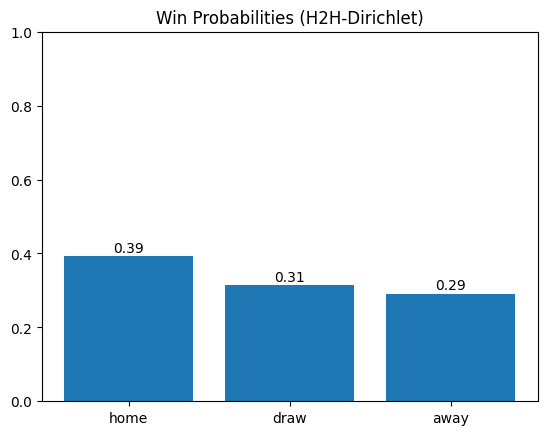

In [12]:
import matplotlib.pyplot as plt

probs = winprob["probs"] if "winprob" in locals() else rc.handle(
    {"intent": "analysis.winprob", "args": {"eventId": event_id, "source": "h2h"}}
)["data"]["probs"]

labels = list(probs.keys())
values = [probs[k] for k in labels]

plt.figure()
plt.bar(labels, values)
plt.title("Win Probabilities (H2H-Dirichlet)")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()